In [11]:
import pandas as pd
import numpy as np
from scipy import stats
import scikit_posthocs as sp # https://pypi.org/project/scikit-posthocs/
import matplotlib.pyplot as plt
import scipy

# Read in our data for comparing

In [12]:
# Assumes a formattting where rows are datasets, and the methods are columns
df = pd.read_csv("ranking.csv", index_col=0)
data = np.asarray(df)/100

print("Read data")

# To be safe, ensure this matches what was expected
num_datasets, num_methods = data.shape
print("Methods:", num_methods, "Datasets:", num_datasets)

Read data
Methods: 4 Datasets: 22


In [13]:
data

array([[0.686 , 0.678 , 0.6841, 0.5753],
       [0.8755, 0.8664, 0.8741, 0.8418],
       [0.961 , 0.9586, 0.9501, 0.9423],
       [0.9702, 0.9636, 0.9608, 0.8994],
       [0.8203, 0.7952, 0.8121, 0.7403],
       [0.9616, 0.94  , 0.9505, 0.8559],
       [0.8429, 0.8367, 0.8252, 0.7831],
       [0.8919, 0.8613, 0.8741, 0.7013],
       [0.902 , 0.886 , 0.774 , 0.749 ],
       [0.998 , 0.998 , 0.966 , 0.936 ],
       [0.785 , 0.783 , 0.769 , 0.771 ],
       [1.    , 1.    , 0.997 , 1.    ],
       [1.    , 1.    , 0.99  , 0.99  ],
       [0.933 , 0.921 , 0.845 , 0.843 ],
       [0.972 , 0.972 , 0.947 , 0.947 ],
       [0.622 , 0.597 , 0.558 , 0.54  ],
       [0.586 , 0.566 , 0.569 , 0.559 ],
       [0.535 , 0.521 , 0.523 , 0.52  ],
       [0.914 , 0.89  , 0.832 , 0.805 ],
       [0.929 , 0.924 , 0.906 , 0.918 ],
       [0.821 , 0.808 , 0.709 , 0.706 ],
       [0.933 , 0.919 , 0.646 , 0.532 ]])

## Friedman testing 
Non parametric test to check if there is a difference in means between the groups (classifiers)

In [14]:
alpha = 0.05 # Set this to the desired alpha/signifance level

stat, p = stats.friedmanchisquare(*data)

reject = p <= alpha
print("Should we reject H0 (i.e. is there a difference in the means) at the", (1-alpha)*100, "% confidence level?", reject)

Should we reject H0 (i.e. is there a difference in the means) at the 95.0 % confidence level? True


In [17]:
ranks = np.array([stats.rankdata(-row, method='average') for row in data])
average_ranks = np.mean(ranks, axis=0)

In [18]:
print(average_ranks)

[1.11363636 2.25       2.86363636 3.77272727]


### Post Hoc Analysis
See [Statistical Comparisons of Classifiers over Multiple Data Sets](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.141.3142&rep=rep1&type=pdf) for more detail

In [129]:
# At this point, we should only continue if H0 was rejected
if not reject:
    raise Exception("Exiting early. The rankings are only relevant if there was a difference in the means i.e. if we rejected h0 above")

In [130]:
# Helper functions for performing the statistical tests
def generate_scores(method, method_args, data, labels):
    pairwise_scores = method(data, **method_args) # Matrix for all pairwise comaprisons
    pairwise_scores.set_axis(labels, axis='columns', inplace=True) # Label the cols
    pairwise_scores.set_axis(labels, axis='rows', inplace=True) # Label the rows, note: same label as pairwise combinations
    return pairwise_scores

def plot(scores):
    # Pretty plot of significance
    heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'square': True,
                    'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}

    sp.sign_plot(scores, **heatmap_args)

#### Nemenyi Test
Note: This is relevant when you would like to compare various methods.
For example if you propose several methods and want to compare them all against each
other, or to do an exhaustive comparison against several method. Often this is not
what we want, as we propose only one method (instead see Bonferoni below), and this would
be overconservativew. 

In [131]:
nemenyi_scores = generate_scores(sp.posthoc_nemenyi_friedman, {}, data, df.columns)

/tmp/ipykernel_327723/3969716403.py:4: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  pairwise_scores.set_axis(labels, axis='columns', inplace=True) # Label the cols
/tmp/ipykernel_327723/3969716403.py:5: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  pairwise_scores.set_axis(labels, axis='rows', inplace=True) # Label the rows, note: same label as pairwise combinations


In [132]:
# Shows the p values for each pair
nemenyi_scores

,DTSemNet,DGT,TAO,CART
DTSemNet,1.000000,0.018422,0.001000,0.001000
DGT,0.018422,1.000000,0.393303,0.001000
TAO,0.001000,0.393303,1.000000,0.089986
CART,0.001000,0.001000,0.089986,1.000000


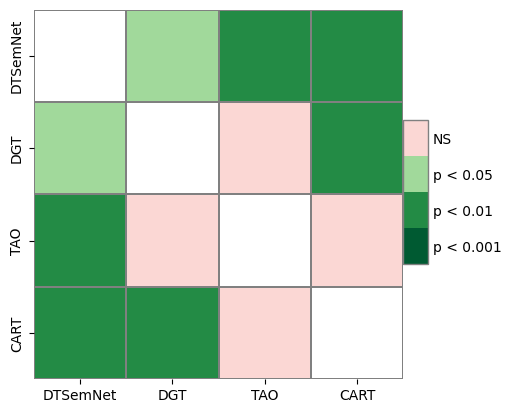

In [133]:
plot(nemenyi_scores)

#### Bonferoni-Holm Correction
In some cases, we do not care about all pairwise comparisons as we only propose a single method.
In this case we can prefer using the Bonferroni correction with a a control method, where the 
control is our proposed method.  This is confirmed in Statistical Comparisons of Classifiers over Multiple Data Sets with

"We thus should not make pairwise comparisons when we in fact only test whether a newly proposed method is better than the existing ones."

This is done with the "Holm" method here


**NOTE:** This relies on the method being called "*Proposed Method*" in the imported CSV file,
for lack of a generic way to set the control group.

In [134]:
def friedman_test(*args):
    """
        Performs a Friedman ranking test.
        Tests the hypothesis that in a set of k dependent samples groups (where k >= 2) at least two of the groups represent populations with different median values.
        
        Parameters
        ----------
        sample1, sample2, ... : array_like
            The sample measurements for each group.
            
        Returns
        -------
        F-value : float
            The computed F-value of the test.
        p-value : float
            The associated p-value from the F-distribution.
        rankings : array_like
            The ranking for each group.
        pivots : array_like
            The pivotal quantities for each group.
            
        References
        ----------
        M. Friedman, The use of ranks to avoid the assumption of normality implicit in the analysis of variance, Journal of the American Statistical Association 32 (1937) 674–701.
        D.J. Sheskin, Handbook of parametric and nonparametric statistical procedures. crc Press, 2003, Test 25: The Friedman Two-Way Analysis of Variance by Ranks
    """
    k = len(args)
    if k < 2: raise ValueError('Less than 2 levels')
    n = len(args[0])
    if len(set([len(v) for v in args])) != 1: raise ValueError('Unequal number of samples')

    rankings = []
    for i in range(n):
        row = [col[i] for col in args]
        row_sort = sorted(row)
        rankings.append([row_sort.index(v) + 1 + (row_sort.count(v)-1)/2. for v in row])

    rankings_avg = [np.mean([case[j] for case in rankings]) for j in range(k)]
    rankings_cmp = [r/np.sqrt(k*(k+1)/(6.*n)) for r in rankings_avg]

    chi2 = ((12*n)/float((k*(k+1))))*((np.sum(r**2 for r in rankings_avg))-((k*(k+1)**2)/float(4)))
    iman_davenport = ((n-1)*chi2)/float((n*(k-1)-chi2))

    p_value = 1 - stats.f.cdf(iman_davenport, k-1, (k-1)*(n-1))

    return iman_davenport, p_value, rankings_avg, rankings_cmp


def holm_test(ranks, control=None):
    """
        Performs a Holm post-hoc test using the pivot quantities obtained by a ranking test.
        Tests the hypothesis that the ranking of the control method is different to each of the other methods.
        
        Parameters
        ----------
        pivots : dictionary_like
            A dictionary with format 'groupname':'pivotal quantity' 
        control : string optional
            The name of the control method (one vs all), default None (all vs all) 
            
        Returns
        ----------
        Comparions : array-like
            Strings identifier of each comparison with format 'group_i vs group_j'
        Z-values : array-like
            The computed Z-value statistic for each comparison.
        p-values : array-like
            The associated p-value from the Z-distribution wich depends on the index of the comparison
        Adjusted p-values : array-like
            The associated adjusted p-values wich can be compared with a significance level
            
        References
        ----------
        O.J. S. Holm, A simple sequentially rejective multiple test procedure, Scandinavian Journal of Statistics 6 (1979) 65–70.
    """
    k = len(ranks)
    values = list(ranks.values())
    keys = list(ranks.keys())
    if not control :
        control_i = values.index(min(values))
    else:
        print(keys)
        control_i = keys.index(control)

    comparisons = [keys[control_i] + " vs " + keys[i] for i in range(k) if i != control_i]
    z_values = [abs(values[control_i] - values[i]) for i in range(k) if i != control_i]
    p_values = [2*(1-stats.norm.cdf(abs(z))) for z in z_values]
    # Sort values by p_value so that p_0 < p_1
    p_values, z_values, comparisons = map(list, zip(*sorted(zip(p_values, z_values, comparisons), key=lambda t: t[0])))
    adj_p_values = [min(max((k-(j+1))*p_values[j] for j in range(i+1)), 1) for i in range(k-1)]
    
    return comparisons, z_values, p_values, adj_p_values

In [135]:
# This library requires the data in different format to above, so was tranposed
statistic, p_value, ranking, rank_cmp  = friedman_test(*np.transpose(data))
ranks = {key: rank_cmp[i] for i, key in enumerate(list(df.columns))} 
print(ranks)

comparisons, z_values, p_values, adj_p_values = holm_test(ranks, control="DTSemNet")
adj_p_values = np.asarray(adj_p_values)

{'DTSemNet': 9.984248958871532, 'DGT': 7.064877918265821, 'TAO': 5.488417556338737, 'CART': 3.152920723854168}
['DTSemNet', 'DGT', 'TAO', 'CART']


/tmp/ipykernel_327723/3021508168.py:41: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  chi2 = ((12*n)/float((k*(k+1))))*((np.sum(r**2 for r in rankings_avg))-((k*(k+1)**2)/float(4)))


In [136]:
# Rankings
for method, rank in ranks.items():
    print(method +":", "%.2f" % rank)

DTSemNet: 9.98
DGT: 7.06
TAO: 5.49
CART: 3.15


In [137]:
holm_scores = pd.DataFrame({"p": adj_p_values, "sig": adj_p_values < alpha}, index=comparisons)

In [138]:
holm_scores

,p,sig
DTSemNet vs CART,2.523981e-11,True
DTSemNet vs TAO,1.385973e-05,True
DTSemNet vs DGT,3.507385e-03,True


# Regression

In [1]:
import numpy as np
import pandas as pd

# Sample data: RMSE values for 3 models across 5 datasets
data = {
    'Dataset1': [2.135, 2.144, 2.15, 2.07, 2.29],
    'Dataset2': [2.645, 2.645, 2.91, 2.58, 3.35],
    'Dataset3': [1.66, 1.67, 1.72, 1.74, 2.01],
    'Dataset4': [1.45, 1.78, 2.30, 1.16, 5.78],
    'Dataset5': [8.99, 9.02, 9.05, 9.08, 9.69]
}

# Convert to DataFrame
df = pd.DataFrame(data, index=['DTSemNet', 'DGT-L', 'DGT', 'TAO-L', 'CART'])
print(df)


          Dataset1  Dataset2  Dataset3  Dataset4  Dataset5
DTSemNet     2.135     2.645      1.66      1.45      8.99
DGT-L        2.144     2.645      1.67      1.78      9.02
DGT          2.150     2.910      1.72      2.30      9.05
TAO-L        2.070     2.580      1.74      1.16      9.08
CART         2.290     3.350      2.01      5.78      9.69


In [3]:
from scipy.stats import friedmanchisquare

# Transpose the DataFrame to have models as columns
df_transposed = df.T

# Perform the Friedman test
stat, p = friedmanchisquare(df_transposed['DTSemNet'], df_transposed['DGT-L'], df_transposed['DGT'], df_transposed['TAO-L'], df_transposed['CART'])
print('Friedman test statistic=%.3f, p-value=%.3f' % (stat, p))

# Interpret the result
alpha = 0.05
if p < alpha:
    print('Significant differences found (reject H0)')
else:
    print('No significant differences found (fail to reject H0)')


Friedman test statistic=14.020, p-value=0.007
Significant differences found (reject H0)


In [6]:
import scikit_posthocs as sp

# Calculate the ranks
ranks = df.rank(axis=0, method='average')
print(ranks)
average_ranks = ranks.mean(axis=1)
print("Average ranks of the models:\n", average_ranks)

# Perform the Nemenyi post-hoc test
nemenyi_results = sp.posthoc_nemenyi_friedman(ranks.T)
print(nemenyi_results)


          Dataset1  Dataset2  Dataset3  Dataset4  Dataset5
DTSemNet       2.0       2.5       1.0       2.0       1.0
DGT-L          3.0       2.5       2.0       3.0       2.0
DGT            4.0       4.0       3.0       4.0       3.0
TAO-L          1.0       1.0       4.0       1.0       4.0
CART           5.0       5.0       5.0       5.0       5.0
Average ranks of the models:
 DTSemNet    1.7
DGT-L       2.5
DGT         3.6
TAO-L       2.2
CART        5.0
dtype: float64
          DTSemNet     DGT-L       DGT     TAO-L      CART
DTSemNet  1.000000  0.900000  0.317206  0.900000  0.008581
DGT-L     0.900000  1.000000  0.781071  0.900000  0.090417
DGT       0.317206  0.781071  1.000000  0.610810  0.610810
TAO-L     0.900000  0.900000  0.610810  1.000000  0.040902
CART      0.008581  0.090417  0.610810  0.040902  1.000000


## RL

In [32]:
# Assumes a formattting where rows are datasets, and the methods are columns
df = pd.read_csv("ranking_rl.csv", index_col=0)
data = np.asarray(df)/100

print("Read data")

# To be safe, ensure this matches what was expected
num_datasets, num_methods = data.shape
print("Methods:", num_methods, "Datasets:", num_datasets)

Read data
Methods: 5 Datasets: 4


In [33]:
alpha = 0.05 # Set this to the desired alpha/signifance level

stat, p = stats.friedmanchisquare(*data)

reject = p <= alpha
print("Should we reject H0 (i.e. is there a difference in the means) at the", (1-alpha)*100, "% confidence level?", reject)

Should we reject H0 (i.e. is there a difference in the means) at the 95.0 % confidence level? True


In [34]:
ranks = np.array([stats.rankdata(-row, method='average') for row in data])
average_ranks = np.mean(ranks, axis=0)

In [35]:
print(average_ranks)

[1.25 2.75 3.   4.75 3.25]


In [36]:
# At this point, we should only continue if H0 was rejected
if not reject:
    raise Exception("Exiting early. The rankings are only relevant if there was a difference in the means i.e. if we rejected h0 above")


/tmp/ipykernel_363819/3699947389.py:4: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  pairwise_scores.set_axis(labels, axis='columns', inplace=True) # Label the cols
/tmp/ipykernel_363819/3699947389.py:5: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  pairwise_scores.set_axis(labels, axis='rows', inplace=True) # Label the rows, note: same label as pairwise combinations


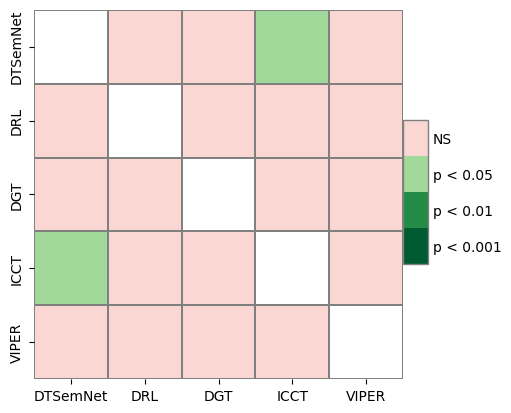

In [37]:

# Helper functions for performing the statistical tests
def generate_scores(method, method_args, data, labels):
    pairwise_scores = method(data, **method_args) # Matrix for all pairwise comaprisons
    pairwise_scores.set_axis(labels, axis='columns', inplace=True) # Label the cols
    pairwise_scores.set_axis(labels, axis='rows', inplace=True) # Label the rows, note: same label as pairwise combinations
    return pairwise_scores

def plot(scores):
    # Pretty plot of significance
    heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'square': True,
                    'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}

    sp.sign_plot(scores, **heatmap_args)

nemenyi_scores = generate_scores(sp.posthoc_nemenyi_friedman, {}, data, df.columns)

# Shows the p values for each pair
nemenyi_scores

plot(nemenyi_scores)

In [38]:
nemenyi_scores


,DTSemNet,DRL,DGT,ICCT,VIPER
DTSemNet,1.000000,0.643932,0.517029,0.015044,0.381128
DRL,0.643932,1.000000,0.900000,0.381128,0.900000
DGT,0.517029,0.900000,1.000000,0.517029,0.900000
ICCT,0.015044,0.381128,0.517029,1.000000,0.643932
VIPER,0.381128,0.900000,0.900000,0.643932,1.000000
